# ADA Project : Milestone 2

## Into the male gaze...

Abstract

First, import the necessary libraries and define our data paths:

In [44]:
# Utilitaries

import pandas as pd
import numpy as np

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import math
import os

# External libraries needed for the project:

#!pip install stanza
#pip install deplacy
#pip install empath
#pip install thefuzz

#Natural language processing libraries:
import stanza
import deplacy
from thefuzz import process
from empath import Empath 
from CoreNLPanalysis import *

#PCA:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Avoid copy warnings:
import warnings
lexicon = Empath()

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [45]:
warnings.filterwarnings('ignore')

# 1. Data importation

In [46]:
google_colab = False
if google_colab:
    data_folder = '/content/sample_data/'
else:
    data_folder = './Data/'

In [47]:
#Loading character metadata:
characters = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header = None)
characters.columns = ('Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
              'Character name', 'Actor date of birth', 'Actor gender',
              'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 
              'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 
              'Freebase actor ID')
characters['Movie release date'] = pd.to_datetime(characters['Movie release date'], errors = 'coerce').dt.year

# change all formats to datetime and keep the year only
# Many of the date formats are inconsistent. 
# Here we convert it all to just year as this is the temporal resolution in which we are interested

In [48]:
#Loading movie metadata:
movies = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movies.columns = ('Wikipedia movie ID' , 'Freebase movie ID' , 'Movie name' , 
                'Movie release date' , 'Movie box office revenue' , 
                'Movie runtime' , 'Movie languages' , 'Movie countries' , 'Movie genres')

movies['Movie release date'] = pd.to_datetime(movies['Movie release date'], errors = 'coerce').dt.year

In [49]:
# Loading plot summaries:
df_plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t')
df_plot_summaries.columns = ['Wikipedia movie ID', 'Plot Summary']
print("There are", len(df_plot_summaries), "plot summaries")

There are 42302 plot summaries


# 2. Preliminary Analysis

#### Characters Preliminary

In [50]:
movies.sample(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
7399,23101996,/m/064kfzd,Guy,1997.0,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}"
15470,28315554,/m/0cp0kms,Kandagar,2010.0,15000000.0,103.0,{},{},"{""/m/07s9rl0"": ""Drama""}"
49411,20536322,/m/0521tx9,Woodchipper Massacre,1988.0,NaN,90.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0qdzd"": ""B-movie"", ""/m/03npn"": ""Horror"", ..."


In [51]:
print('There are {} entries in the movies dataset'.format(len(movies)))

There are 81741 entries in the movies dataset


In [8]:
for name, values in movies.items():
    print ('{:.4} % of movies have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of movies have an associated Wikipedia movie ID
100.0 % of movies have an associated Freebase movie ID
100.0 % of movies have an associated Movie name
91.56 % of movies have an associated Movie release date
10.28 % of movies have an associated Movie box office revenue
74.98 % of movies have an associated Movie runtime
100.0 % of movies have an associated Movie languages
100.0 % of movies have an associated Movie countries
100.0 % of movies have an associated Movie genres


**Note :** Any analysis based on the movie revenue (as a measure of success) will need extra information, as probably basing the study only in 10% of the data is not enough.



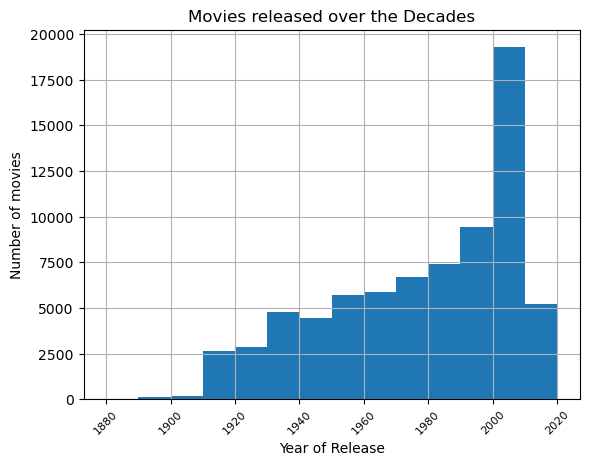

In [9]:
fig, ax = plt.subplots()
ax = movies['Movie release date'].hist(bins = range(1880,2030,10), grid = True, xlabelsize = 8 ,xrot = 45)
plt.xlabel('Year of Release')
plt.ylabel('Number of movies')
plt.title('Movies released over the Decades');

**Note:** On 16 December 2014, Google announced that it would shut down Freebase over the succeeding six months and help with the move of the data from Freebase to Wikidata. Data collection does not go through the entire 2010's decade

In [10]:
print('The dataset is comprised of movies with known releases between {0:n} and {1:n} '.format(movies['Movie release date'].min(), 
                                                                                               movies['Movie release date'].max()))

The dataset is comprised of movies with known releases between 1888 and 2016 


In [11]:
rmovies = movies[movies['Movie box office revenue'].notnull()]

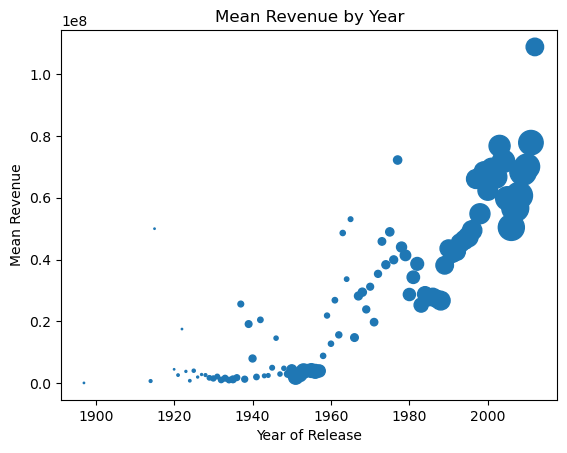

In [12]:
r_by_year = rmovies.groupby("Movie release date")['Movie box office revenue'].agg(['mean','size']).reset_index()
r_by_year.plot(kind = 'scatter', x = 'Movie release date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean Revenue')
plt.xlabel('Year of Release');

From the above plot we see that the mean revenues increase over time. It would be interesting to normalize this by inflation or perhaps some share of GDP. We also see that there is much more data present in the later years (dot size scaled by amount of revenues averaged to form datapoint. 1897 - 1 movie revenue, 2008 - 367 movie revenues)

In [13]:
def correct_countries(x):
    if len(x)>2:
        x= x.split(':')[1][0:-1]
        res = x.split('"')[1]
    else:
        res = 'NA' 
    return res

movies["Movie countries corrected"]= movies["Movie countries"].apply(lambda x: correct_countries(x))

In [18]:
c_movies_filt = pd.DataFrame(movies.groupby(["Movie release date","Movie countries corrected"]).size()).reset_index()
c_movies_filt = c_movies_filt.set_axis(["Movie release date", "Movie countries corrected", 'Count'], axis='columns')
c_movies_filt

,Movie release date,Movie countries corrected,Count
0,1888.0,United Kingdom,1
1,1889.0,United Kingdom,1
2,1890.0,United Kingdom,1
3,1890.0,United States of America,1
4,1891.0,NA,2
...,...,...,...
4109,2014.0,United States of America,4
4110,2015.0,NA,2
4111,2015.0,United States of America,2
4112,2016.0,NA,1


In [19]:
most_common_count = movies.groupby(["Movie countries corrected"]).size().reset_index()
most_common_count = most_common_count.set_axis(["Country", "Number of movies"], axis='columns')
most_common_count.drop(most_common_count[most_common_count['Country'] == 'NA'].index, inplace = True)
most_common_count = most_common_count.sort_values("Number of movies", ascending=False)[0:10]
most_common_count

,Country,Number of movies
124,United States of America,34118
51,India,8294
123,United Kingdom,5477
40,France,3996
60,Japan,2321
58,Italy,1925
21,Canada,1471
3,Argentina,1291
48,Hong Kong,1120
5,Australia,874


In [20]:
top10_country_data = c_movies_filt[c_movies_filt['Movie countries corrected'].isin(most_common_count['Country'])]

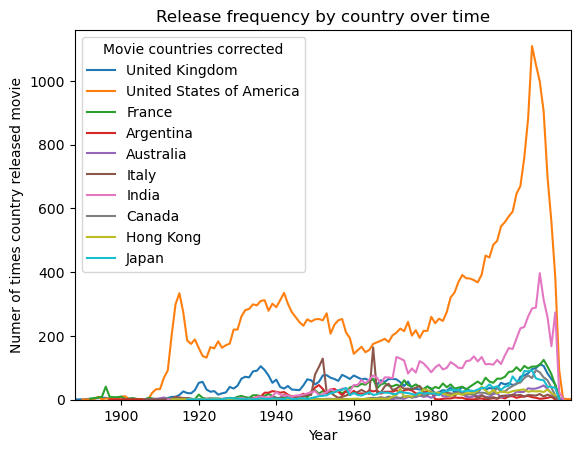

In [21]:
sns.lineplot(x='Movie release date', y='Count',data = top10_country_data, hue = 'Movie countries corrected', legend=True)
plt.xlabel("Year")
plt.ylabel("Numer of times country released movie")
plt.title("Release frequency by country over time")
plt.ylim([0,top10_country_data['Count'].max()+50])
plt.xlim([top10_country_data['Movie release date'].min(), top10_country_data['Movie release date'].max()]);
#plt.yscale('log')

#### Characters Preliminary

In [22]:
characters.sample(3)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
58834,24301781,/m/07scj0r,1964.0,NaN,1935-01-09,M,NaN,NaN,Bob Denver,NaN,/m/07ssxhy,NaN,/m/018hgr
318594,3578467,/m/09mrk_,1977.0,NaN,1933-11-09,M,NaN,NaN,Robert Gillespie,43.0,/m/0k1n79,NaN,/m/0ck208
257826,14781533,/m/04gh3n0,2008.0,NaN,1955-01-18,M,1.85,/m/09vc4s,Kevin Costner,53.0,/m/0gxk9y4,NaN,/m/0127m7


In [23]:
print('There are {} entries in the characters dataset'.format(len(characters)))

There are 450669 entries in the characters dataset


In [24]:
for name, values in characters.items():
    print ('{:.4} % of characters have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of characters have an associated Wikipedia movie ID
100.0 % of characters have an associated Freebase movie ID
97.78 % of characters have an associated Movie release date
42.78 % of characters have an associated Character name
76.45 % of characters have an associated Actor date of birth
89.88 % of characters have an associated Actor gender
34.35 % of characters have an associated Actor height (in meters)
23.53 % of characters have an associated Actor ethnicity (Freebase ID)
99.73 % of characters have an associated Actor name
64.92 % of characters have an associated Actor age at movie release
100.0 % of characters have an associated Freebase character/actor map ID
42.78 % of characters have an associated Freebase character ID
99.82 % of characters have an associated Freebase actor ID


In [25]:
#we see lots of NA ages at release... lets drop those
char_filt_age = characters[characters['Actor age at movie release'].notnull()]

In [26]:
char_filt_age.loc[char_filt_age['Actor age at movie release']<0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934.0,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918.0,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965.0,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924.0,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955.0,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999.0,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955.0,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944.0,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941.0,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


**Note:** In the dataframe above we see 381 instances of negative ages. By taking the difference between the actor date of birth and movie release date we realize that the actor age is correct in magnitude but not in sign. Below, we correct the column by taking its absolute value.

In [27]:
char_filt_age.loc[char_filt_age['Actor age at movie release'] < 0, 
                  'Actor age at movie release'] = char_filt_age['Actor age at movie release'].abs()

In [28]:
print('Only {:.4} % of charactors have an associated actor age at release'.format(100 * len(char_filt_age)/len(characters)))

Only 64.92 % of charactors have an associated actor age at release


In [29]:
char_age_grouped = char_filt_age.groupby(["Movie release date", "Actor gender"])['Actor age at movie release'].agg(['mean','size']).reset_index()


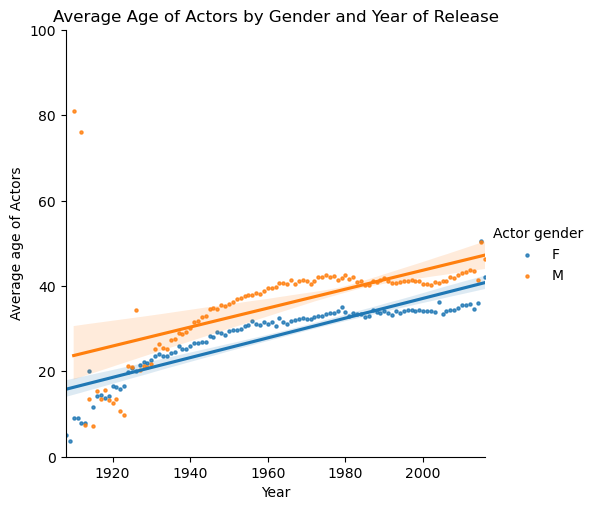

In [30]:
# Here we break down the analysis by gender, 

sns.lmplot(x="Movie release date", y='mean',data = char_age_grouped, hue = 'Actor gender', scatter_kws={"s":5})
plt.xlabel("Year")
plt.ylabel("Average age of Actors")
plt.title("Average Age of Actors by Gender and Year of Release")
plt.ylim([0,100])
plt.xlim([char_age_grouped["Movie release date"].min(),char_age_grouped["Movie release date"].max()]);

In [31]:
avg_age_M = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'M']['Actor age at movie release'].mean(),0)
avg_age_F = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'F']['Actor age at movie release'].mean(),0)
print('The average age for male actors is ', avg_age_M, ', whereas for actresses it is ', avg_age_F)

The average age for male actors is  40.0 , whereas for actresses it is  33.0


In the above figure we are displaying the average age at movie release for female and male actors, as well as the linear regression of the average age evolution over time. The shaded areas represent the 95% confidence interval for the regression.

It is interesting to note that males tend to be older than women in cinema over the last hundred years (at least since 1940). This difference observed in the plot is also confirmed by the computed overall average age at realease for both genders (40 for men compared to 33 for women). 

We can also observe a tendency to employ older actors in movies. One of the hypothesis for this fact is that the age at release data is lacking for older actors at the beginning of the 20th century. Record keeping was not as good as it is now. This could be an explanation for the fact that the data we do have on actors with roles in the early 20th century are all quite young - ie they lived long enough to enter modern database management. 

In [32]:
char_gen = pd.DataFrame(characters.groupby(['Movie release date', 'Actor gender'])['Actor gender'].agg('size')).rename(columns={'Actor gender' : 'Count'}).reset_index()
char_gen['Gender Percentage'] = char_gen['Count'] / char_gen.groupby('Movie release date')['Count'].transform('sum')*100
char_gen = char_gen.loc[char_gen['Actor gender'] == 'F']
char_gen.head()

,Movie release date,Actor gender,Count,Gender Percentage
0,1888.0,F,2,50.000000
4,1894.0,F,1,25.000000
7,1896.0,F,5,55.555556
9,1897.0,F,2,66.666667
11,1898.0,F,1,25.000000


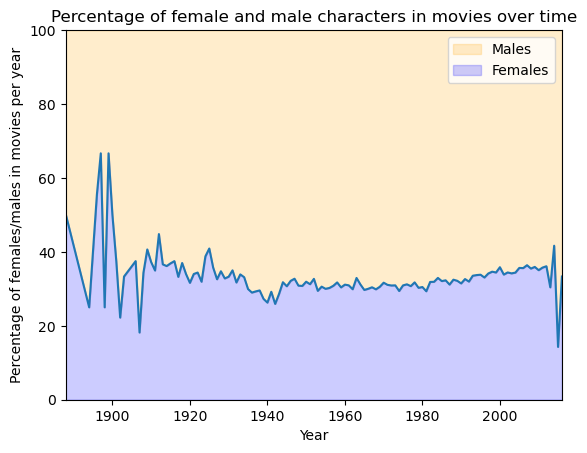

In [33]:
ax = sns.lineplot(x='Movie release date', y='Gender Percentage',data = char_gen, legend=True)
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, 100, color="orange", alpha=0.2, label = 'Males')

ax.fill_between(x1, y1, color="blue", alpha=0.2, label = 'Females')
plt.xlabel("Year")
plt.ylabel("Percentage of females/males in movies per year")
plt.title("Percentage of female and male characters in movies over time")
plt.ylim([0,100])
plt.xlim([char_gen['Movie release date'].min(), char_gen['Movie release date'].max()])
plt.legend()

#plt.yscale('log')

We see more dynamic behavior in the earlier years. This is due to small sample sizes which lead to large spikes in % for small deviations. We see it stabilize for a majority of the graph before once again entering erratic territory in the last years (data collection was limited in the 2010's). The most obvious takeaway is that male characters are more common than female characters

In [34]:
# Checking when either character name or Freebase movie ID are missing:
print('Missing "character names" in character metadata: %d' %characters['Character name'].isnull().sum())
print('Missing "Freebase character" IDs in character metadata: %d' %characters['Freebase character ID'].isnull().sum())
print('We can see that the number of missing character names ≈ missing Freebase character IDs')
print('There are 10 characters where we have a "Freebase character ID" but not "character names"')
# Checking when both "Character name" and "Freebase character ID are missing":
characters.loc[characters['Character name'].isnull() & characters['Freebase movie ID'].isnull()]
missing_both_IDs = sum(characters.iloc[:, [3, 11]].isnull().all(1))
print('Missing Character name AND Freebase character ID: %d' %missing_both_IDs)
# Checking characters for which we don't have that character name buit we have both the Freebase character/actor map ID and Freebase actor ID
characters.iloc[:, [3, 11]].isnull().all(1) # 4th column and 11th column
poss_recov = sum(characters.iloc[:, [3]].isnull().all(1) & characters.iloc[:, [10, 12]].notnull().all(1))
print('Missing character name but known Freebase character/actor map ID and Freebase actor ID: %d' %poss_recov)

Missing "character names" in character metadata: 257875
Missing "Freebase character" IDs in character metadata: 257865
We can see that the number of missing character names ≈ missing Freebase character IDs
There are 10 characters where we have a "Freebase character ID" but not "character names"
Missing Character name AND Freebase character ID: 257865
Missing character name but known Freebase character/actor map ID and Freebase actor ID: 257389


The previous analysis highlights the possibility of using the available Freebase IDs in order to recover a substantial amount to character names. The Freebase character/actor map will link the Freebase actor ID to the roles that the specific actor will have performed. As a result, we will be able to extract the Freebase character IDs, thus the missing character names. 

In [35]:
''' Merging character with movie metadata with an inner join. We do an inner join 
because there are movies in the movie metadata for which we do not 
have any character information in character metadata and vice versa.
For the future analysis we need both information about the characters
and movie in which they appear'''

df_char_movie = pd.merge(left= characters, right= movies, how='inner', on= ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date'])
print('The total number of characters that we obtain from the inner merge is: %d' %len(df_char_movie))

The total number of characters that we obtain from the inner merge is: 450669


In [36]:
movies_with_characters = df_char_movie.groupby(['Wikipedia movie ID']).agg('size')
print('The resulting number of movies from the merge of characters and movies is: %d'%len(movies_with_characters))

The resulting number of movies from the merge of characters and movies is: 64330


In [37]:
# Computing the total number of characters and the number of character names we have in our dataframe
char_names_per_movie = df_char_movie.groupby('Wikipedia movie ID')['Character name'].count() # extracts number of characters we have (i.e. not coun ting NaNs)
total_characters_per_movie = df_char_movie.groupby(['Wikipedia movie ID'])['Character name'].agg(['size'])

In [38]:
df_character_missing_stats = pd.merge(total_characters_per_movie, char_names_per_movie, on='Wikipedia movie ID')
df_character_missing_stats['n°_missing_characters'] = df_character_missing_stats['size'] - df_character_missing_stats['Character name']
df_character_missing_stats['percentage_missing'] = round(100 * df_character_missing_stats['n°_missing_characters'] / df_character_missing_stats['size'], 2) # computing percentages of missing character names
df_character_missing_stats['percentage_available'] = 100 - df_character_missing_stats['percentage_missing']
df_character_missing_stats = df_character_missing_stats.rename(columns={'size': 'total_n°_characters (incl. NaN)'})
df_character_missing_stats = df_character_missing_stats.rename(columns={'Character name': 'character_names (excl. NaN)'})
df_character_missing_stats.head()

,total_n°_characters (incl. NaN),character_names (excl. NaN),n°_missing_characters,percentage_missing,percentage_available
Wikipedia movie ID,,,,,
330,4,0,4,100.0,0.0
3217,14,14,0,0.0,100.0
3333,14,0,14,100.0,0.0
3746,15,15,0,0.0,100.0
3837,20,16,4,20.0,80.0


In the dataframe above we obtain:
- the total amount of characters in a specific movie
- the number of character names for a specific movie
- the percentage of the character names that are missing per movie
- the percentage of the character names that are available per movie

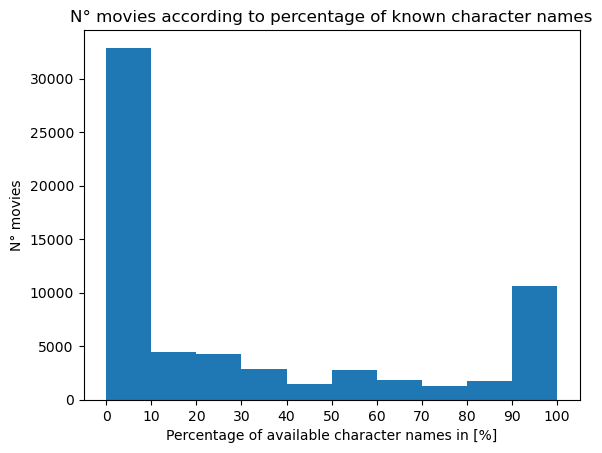

In [39]:
df_character_missing_stats['percentage_available'].hist(bins=10, grid=False)
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('N° movies')
plt.xlabel('Percentage of available character names in [%]')
plt.title('N° movies according to percentage of known character names')
plt.show()

For example: there are roughly 39 000 movies for which we have less than 10% of the character names.

In [40]:
# Let's calculate the percentage of movies for which we have at least 1 character name
# Assuming that the character name that would be available is the one of the main character.

more_1_char = df_character_missing_stats['character_names (excl. NaN)'][df_character_missing_stats['character_names (excl. NaN)'] >= 1].count()
perc_1_char = 100*more_1_char/64329

print('The total number of movies where we have at least one character name is: %d' %more_1_char)
print('The percentage of movies for which we have at least one character name is: %d' %perc_1_char, '%')

The total number of movies where we have at least one character name is: 32571
The percentage of movies for which we have at least one character name is: 50 %


# 3. CoreNLP

In [42]:
'''Now we want to proceed to the analysis of the plots using the CoreNLP model. 
For that we first compare the plot information with the character and movie information, 
to not analyse plots we can not link to other data. The final dataframe contains only the Wikipedia Modie ID and Plot Summaries
which are related to movie and character data'''

df_char_movie_plot = pd.merge(left= df_char_movie, right= df_plot_summaries, how='inner', on= ['Wikipedia movie ID'])
df_plots_filt = df_char_movie_plot[['Wikipedia movie ID','Plot Summary']].drop_duplicates().reset_index()
df_plots_filt = df_plots_filt.drop(columns = ['index'])
df_plots_filt

,Wikipedia movie ID,Plot Summary
0,975900,"Set in the second half of the 22nd century, th..."
1,261236,"Eva, an upper class housewife, becomes frustra..."
2,2238856,The structure of the film consists of several ...
3,18296435,"Serap, a young actress with a strong, lively p..."
4,32456683,"Otto Brosowski, a communist miner, writes to t..."
...,...,...
37773,22545667,Gracie and Laurie are lovers who together fo...
37774,31627556,"Kara , George , and Enzo are 3 best friends w..."
37775,30553937,A daytime soap opera star has to deal with his...
37776,12476867,The movie is about a teenage girl who loves ho...


In [62]:
stanza.download('en') # download English model

2022-11-18 17:59:56 INFO: Downloading default packages for language: en (English) ...
2022-11-18 17:59:58 INFO: File exists: C:\Users\camil\stanza_resources\en\default.zip
2022-11-18 18:00:02 INFO: Finished downloading models and saved to C:\Users\camil\stanza_resources.


In [64]:
nlp = stanza.Pipeline(lang='en', processors='tokenize, pos, lemma, depparse, ner')

2022-11-18 18:00:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-18 18:00:20 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| ner       | ontonotes |

2022-11-18 18:00:20 INFO: Use device: cpu
2022-11-18 18:00:20 INFO: Loading: tokenize
2022-11-18 18:00:20 INFO: Loading: pos
2022-11-18 18:00:20 INFO: Loading: lemma
2022-11-18 18:00:22 INFO: Loading: depparse
2022-11-18 18:00:22 INFO: Loading: ner
2022-11-18 18:00:23 INFO: Done loading processors!


**Note 1:** 
The two following cells should not be ran locally, because of the computational cost. Instead, we used Google Colab with GPU option to run the NLP analysis and create the resulting dataset. Here we keep it for a good understanding of the workflow. The result of the analysis is in the Data folder, and we can import it directly from there.

**Note 2:**
The `Analyse_Plots` function is in a *separated python file*, to avoid any information not critical to the understanding of our analysis. It is then imported from `CoreNLPanalysis.py`.

In [ ]:
df_NLP = Analyse_Plots(df_plots_filt, nlp)  

In [ ]:
df_NLP.to_csv(data_folder + "Plot_NLP_Analysis.csv", sep='\t', header=None)

In [54]:
# Loading the data obtained from the NLP pipeline:
df_1 = pd.read_csv(data_folder + "Plot_NLP_Analysis_0_14100.csv", sep='\t', header = None)
df_2 = pd.read_csv(data_folder + "Plot_NLP_Analysis_14101_23201.csv", sep='\t', header = None)
df_3 = pd.read_csv(data_folder + "Plot_NLP_Analysis23202-42302.csv", sep='\t', header = None)
df_1 = df_1.drop(columns=0)
df_2 = df_2.drop(columns=0)
df_3 = df_3.drop(columns=0)
clusters_df = pd.concat([df_1, df_2, df_3], ignore_index=True)
clusters_df.columns = ('Wikipedia movie ID', 'Character partial name', 'Agent Verbs', 'Patient Verbs', 'Attributes')

In [55]:
clusters_df

,Wikipedia movie ID,Character partial name,Agent Verbs,Patient Verbs,Attributes
0,23890098,Lyosha,0.0,0.0,driver taxi
1,31186339,Primrose,0.0,['chosen'],old
2,31186339,Katniss,"['volunteers', 'survives', 'drops', 'has', 'ru...","['gave', 'taken', 'warned', 'presented']",sister love
3,31186339,Peeta,"['tribute', 'reveals', 'meant', 'forms', 'begs...",0.0,tribute mobile victorious
4,31186339,Haymitch,"['able', 'warns']",0.0,victor advice able star rule
...,...,...,...,...,...
150631,8628195,Amina,['forgotten'],0.0,daughter
150632,8628195,Rehman,"['abuses', 'tries', 'states', 'forgotten', 'tr...",['gives'],lawyer honesty daughter
150633,8628195,Mini,"['short', 'decides', 'goes', 'tolerate', 'stop...",0.0,father budget wedding
150634,6040782,Arthur,0.0,0.0,clerk


In [58]:
# TO COMMENT !!!!!

In [56]:
df_char_movie_names = df_char_movie[['Wikipedia movie ID','Character name']].dropna()
df_char_movie_names['All_names'] = df_char_movie_names.groupby(['Wikipedia movie ID'], 
            as_index = True)['Character name'].transform(lambda x: ','.join(x))
df_char_movie_names = df_char_movie_names[['Wikipedia movie ID', 'All_names']].drop_duplicates()
df_char_movie_names['All_names'] = [x.strip('()').split(',') for x in df_char_movie_names['All_names']]

In [57]:
clusters_df = clusters_df.merge(df_char_movie_names, how = 'inner', on = 'Wikipedia movie ID')
clusters_df.head(3)

,Wikipedia movie ID,Character partial name,Agent Verbs,Patient Verbs,Attributes,All_names
0,31186339,Primrose,0.0,['chosen'],old,"[Foxface, Katniss Everdeen, Peeta Mellark, Eff..."
1,31186339,Katniss,"['volunteers', 'survives', 'drops', 'has', 'ru...","['gave', 'taken', 'warned', 'presented']",sister love,"[Foxface, Katniss Everdeen, Peeta Mellark, Eff..."
2,31186339,Peeta,"['tribute', 'reveals', 'meant', 'forms', 'begs...",0.0,tribute mobile victorious,"[Foxface, Katniss Everdeen, Peeta Mellark, Eff..."


**Note:** Same as previously, we will not run those following cells, but they are useful to understand where our data comes from.

In [ ]:
def matching(col1, col2):
    if process.extractOne(col1, list(col2))[1]>80:
        res = process.extractOne(col1, list(col2))[0]    
    else:
        res = 'Not found'
    return res

clusters_df['Full_name'] = clusters_df.apply(lambda x: matching(x['Character partial name'],
                                                                            x['All_names']), axis=1)
clusters_df.tail(50)

In [ ]:
char_df = clusters_df.loc[clusters_df['Full_name'] != 'Not found']

In [ ]:
categories = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i,cat in enumerate(categories):
    rem = char_df[cat] == '0.0'
    char_df.loc[rem, cat] = char_df.loc[rem, cat].replace('0.0', '')
char_df['All_Agent_Verbs'] = char_df.groupby(['Full_name'])['Agent Verbs'].transform(lambda x: ','.join(x))
char_df['All_Patient_Verbs'] = char_df.groupby(['Full_name'])['Patient Verbs'].transform(lambda x: ','.join(x))
char_df['All_Attributes'] = char_df.groupby(['Full_name'])['Attributes'].transform(lambda x: ','.join(x))

In [ ]:
char_df = char_df[['Wikipedia movie ID', 'Full_name', 'All_Agent_Verbs', 'All_Patient_Verbs', 'All_Attributes']]

In [ ]:
char_df.to_csv(data_folder + "Characters_Matched_DF_Clean.csv", sep='\t', header=None)

### Case study example for NLP analysis result for one movie : "Bhagwan Dada", movie ID 10644072 


In [60]:
#Let's first extract the beginning of the plot summary of Bhagwan Dada, movie ID 10644072.

text_extract_10644072 = '''A villager new to the big city – Bhagwaan  – turns to crime to avoid starvation. He is drawn into the gang of slum crime lord ‘dada’ Shambu  where he falls into every crime but one: violence against women. When an impoverished but honourable young widow hangs herself after being raped by Shambu Dada, the cries of her orphaned baby awaken Bhagwaan’s soul. He rebels against his former master. Bhagwaan vows to atone for his formerly evil life, and adopts the orphaned baby as his own son. The innocent young boy becomes Bhagwaan’s source of personal redemption and the inspiration for all that he does. 12 years later the man now lovingly hailed as “Bhagwaan Dada” has transformed the former crime-ridden slum into a safe and happy neighbourhood - Shantinagar - where his adopted son Govinda  has become the pride and joy of the whole community. Despite his own dark past, this loving father has worked hard to raise the boy as a good person with sound moral values. At this time, Bhagwaan chances to rescue another naïve young man new to the big city – Swaroop  – when Shambu Dada’s gang steal all Swaroop’s money. Impressed with Swaroop’s education as well as the similarity of situation to his own arrival in the city years before, Bhagwaan takes the “innocent and simple” villager under his protective wing. He arranges a good job, even brings Swaroop home to live with himself and his son, young Govinda. Swaroop and Bhagwaan claim each other as ‘brothers’.'''
text_extract_10644072

'A villager new to the big city – Bhagwaan  – turns to crime to avoid starvation. He is drawn into the gang of slum crime lord ‘dada’ Shambu  where he falls into every crime but one: violence against women. When an impoverished but honourable young widow hangs herself after being raped by Shambu Dada, the cries of her orphaned baby awaken Bhagwaan’s soul. He rebels against his former master. Bhagwaan vows to atone for his formerly evil life, and adopts the orphaned baby as his own son. The innocent young boy becomes Bhagwaan’s source of personal redemption and the inspiration for all that he does. 12 years later the man now lovingly hailed as “Bhagwaan Dada” has transformed the former crime-ridden slum into a safe and happy neighbourhood - Shantinagar - where his adopted son Govinda  has become the pride and joy of the whole community. Despite his own dark past, this loving father has worked hard to raise the boy as a good person with sound moral values. At this time, Bhagwaan chances 

In [65]:
# Then, we run the pipeline over the plot summary which will run annotation over each sentence of the plot:
doc_10644072 = nlp(text_extract_10644072)

In [66]:
#Then, we can have a look at the dependencies of the words between each other for the first sentence:
sentence = '''A villager new to the big city – Bhagwaan  – turns to crime to avoid starvation.'''
doc_s = nlp(sentence)
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc_s.sentences for word in sent.words], sep='\n')

id: 1	word: A	head id: 2	head: villager	deprel: det
id: 2	word: villager	head id: 11	head: turns	deprel: nsubj
id: 3	word: new	head id: 2	head: villager	deprel: amod
id: 4	word: to	head id: 7	head: city	deprel: case
id: 5	word: the	head id: 7	head: city	deprel: det
id: 6	word: big	head id: 7	head: city	deprel: amod
id: 7	word: city	head id: 3	head: new	deprel: obl
id: 8	word: –	head id: 9	head: Bhagwaan	deprel: punct
id: 9	word: Bhagwaan	head id: 11	head: turns	deprel: nsubj
id: 10	word: –	head id: 9	head: Bhagwaan	deprel: punct
id: 11	word: turns	head id: 0	head: root	deprel: root
id: 12	word: to	head id: 13	head: crime	deprel: case
id: 13	word: crime	head id: 11	head: turns	deprel: obl
id: 14	word: to	head id: 15	head: avoid	deprel: mark
id: 15	word: avoid	head id: 11	head: turns	deprel: advcl
id: 16	word: starvation	head id: 15	head: avoid	deprel: obj
id: 17	word: .	head id: 11	head: turns	deprel: punct


As we can see, the result show each tokenized word of the sentence, their id, their dependency relationship with other words and their ids in the same sentence. The deprel type relies on the Stanford typed dependencies representation "which was designed to provide a simple description of the grammatical relationships in a sentence" (Marneffe and Manning, 2008).

In [69]:
#We can visualize the results of these annotations with the first sentences of the plot summary with the deplacy library:
deplacy.render(doc_s)
#Here, it also shows the position (pos) of the word, meaning the type of word it is:

A          DET   <══════════╗     det
villager   NOUN  ═════════╗═╝<╗   nsubj
new        ADJ   ═══════╗<╝   ║   amod
to         ADP   <════╗ ║     ║   case
the        DET   <══╗ ║ ║     ║   det
big        ADJ   <╗ ║ ║ ║     ║   amod
city       NOUN  ═╝═╝═╝<╝     ║   obl
–          PUNCT <╗           ║   punct
Bhagwaan   PROPN ═╝═╗<══╗     ║   nsubj
–          PUNCT <══╝   ║     ║   punct
turns      VERB  ═══╗═╗═╝═════╝═╗ root
to         ADP   <╗ ║ ║         ║ case
crime      NOUN  ═╝<╝ ║         ║ obl
to         PART  <══╗ ║         ║ mark
avoid      VERB  ═╗═╝<╝         ║ advcl
starvation NOUN  <╝             ║ obj
.          PUNCT <══════════════╝ punct


In [70]:
#Another type of visualization, maybe more visual, with port=None to be visualized directly within the notebook is the following:
deplacy.serve(doc_s, port=None, RtoL=False)

In [71]:
#Then, we select the plot summary within all the plots, to demonstrate a typical output we get from our pipeline:
plot_10644072 = df_plots_filt[df_plots_filt['Wikipedia movie ID']==10644072].reset_index()
plot_10644072

,index,Wikipedia movie ID,Plot Summary
0,31108,10644072,A villager new to the big city – Bhagwaan – t...


In [72]:
# This may take a lot of time to run (4 hours or more without google colab GPU) if you don't select a subset of plot summaries:
# Here, we select the movie ID of our example and it returns us a dataframe with all the characters (entities) found in the plot summary
# with their corresponding agent verbs, patient verbs and attributes:
df_NLP = Analyse_Plots(plot_10644072, nlp)  
df_NLP

Plot analysed  0  out of  1


,Wikipedia movie ID,Character_Name,Agent Verbs,Patient Verbs,Attributes
0,10644072,Bhagwaan,"[turns, falls, vows, does, chances, takes, doe...","[spills, killed, injured]",soul source inspiration home revenge territory...
1,10644072,Govinda,"[become, mistakes, remaining, invites, late, p...",0.0,son son young young brave little legs murder w...
2,10644072,Swaroop,"[falls, does, claim, hears, soul, hides, loves...","[hears, returned, injured]",city money education city soul wife ecstatic m...
3,10644072,Shambu,"[steal, lusts, sworn, dumps, escaped, vows, la...",[convicted],gang assault gang men activities crime empire ...
4,10644072,Bijli,"[insists, streetwalker, spills, worker, manage...",0.0,streetwalker worker sex fraud attraction behav...
5,10644072,Madhu,"[reciprocates, comes, help]",0.0,reporter newspaper crime exhausted
6,10644072,Geeta,"[discover, goes, realise]",[interrupted],sister wedding


In [73]:
pd.set_option('display.max_colwidth', None)
for elem in ['Shambu', 'Bhagwaan', 'Bijli','Madhu']:
    print(elem,'\'s attributes in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Attributes'].values)
    print(elem,'\'s agent verbs, meaning verbs for which he\'s taking the action in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Agent Verbs'].values)
    print(elem,'\'s patient verbs, meaning verbs for which he is the action\'s subject in the movie plot correspond to :', df_NLP.loc[df_NLP['Character_Name']==elem]['Patient Verbs'].values)
    print('    ')

Shambu 's attributes in the movie plot correspond to : ['gang assault gang men activities crime empire reformation evil escape fugitive gang boots nail dying']
Shambu 's agent verbs, meaning verbs for which he's taking the action in the movie plot correspond to : [list(['steal', 'lusts', 'sworn', 'dumps', 'escaped', 'vows', 'late', 'intended', 'vented', 'confronts', 'manages'])]
Shambu 's patient verbs, meaning verbs for which he is the action's subject in the movie plot correspond to : [list(['convicted'])]
    
Bhagwaan 's attributes in the movie plot correspond to : ['soul source inspiration home revenge territory reformation savvy street invitation jubilant interested end chest legacy']
Bhagwaan 's agent verbs, meaning verbs for which he's taking the action in the movie plot correspond to : [list(['turns', 'falls', 'vows', 'does', 'chances', 'takes', 'does', 'rescue', 'invites', 'realise', 'believes', 'discovers', 'helps', 'invites', 'loves', 'confronts', 'strikes', 'wants', 'late'

Here, we can see that it depicts a quite satisfying big picture of the character, where we can later analyse the lexical field of the words employed in the plot summary to describe him to define the archetype of this character. We can clearly retain from our analysis that Shambu holds a negative and violent description of himself depicted as a fugitive and evil master of the gang Bhagwaan was involved into. Bhagwaan on the contrary is correctly defined in the opposite way in our analysis by his 'soul' and thirst of revenge against his former master. Of course, only the archetype can be deduced from our list of attributes and verbs and not the meaning and relation between the characters, but this will help us to do archetypes comparison between character's genders later in the analysis. Indeed, Bijili and Madhu, both feminine characters, have much less verbs and attributes compared to previous masculine characters and their corresponding verbs are more on the 'victim' side: manages, confesses, help, as well as their attributes: sex worker, attraction, streetwalker etc. Of course, this concerns only one movie and cannot be generalized yet but we are confident about our results and can now move on to merge our outputs of the NLP pipeline with corresponding character names and movie IDs from character and movie metadata.

## 4. Sentiment Analysis

In [74]:
CMdf = pd.read_csv(data_folder + 'Characters_Matched_DF_Clean.csv', sep='\t',index_col = 0)
CMdf.columns = ['Wikipedia movie ID', 'Character name', 'Agent Verbs', 'Patient Verbs', 'Attributes']
CMdf.reset_index(inplace = True,drop=True)
CMdf.drop_duplicates(inplace = True)

In [75]:
CMdf

,Wikipedia movie ID,Character name,Agent Verbs,Patient Verbs,Attributes
0,20663735,M.K. Menon,"['refuses', 'regrets', 'suffers']","['accused', 'judged']",judge jail corruption funeral
1,20663735,Marancheri Induchoodan,",['loses', 'passes', 'thwarts', 'follow', 'falls', 'thrashes', 'decides', 'has', 'returns', 'returns', 'interrupts', 'accepts']",",['framed']","son,dead years state confrontations friend court"
2,595909,Michael Chamberlain,"['holiday', 'uses', 'disintegrate'],['overturned']","['found'],","pastor day faith,convictions"
3,595909,Lindy Chamberlain,"['returns', 'saw', 'seems', 'insisted']","['charged', 'found']",wife
5,5272176,Vaughn Stevens,"['handed'],",",","home,house"
...,...,...,...,...,...
17482,26261438,Kor,NaN,['overjoyed'],townspeople
17483,26261438,Xenos,"['attempts', 'unsuccessful', 'ends']",NaN,priest attempts lack
17484,26261438,Midget Hup,NaN,NaN,sidekick
17485,26261438,Marlenus,['announces'],NaN,death killer


In [76]:
CMdf = pd.merge(left= CMdf, right=df_char_movie, how='inner', on= ['Wikipedia movie ID', 'Character name'])

In [77]:
CMdf_c = CMdf[['Wikipedia movie ID','Character name','Actor gender','Agent Verbs','Patient Verbs','Attributes']]

### Columns kept:
In this section, we extract the following columns for each character:
We keep only these features for the preliminary sentiment analysis: 
- `Wikipedia movie ID`: ID of the movie from wikidata
- `Character name`: character name associated with verbs and attributes
- `Actor gender`
- `Agent Verbs`
- `Patient Verbs`
- `Attributes`

However, for later analysis, we would want to add other interesting features such as:
- `Movie release date`: the release date of the movie the character is from
- `nbr_words`: median of number of words in the plot summary corresponding to the movie ID
- `nbr_characters`: median of number of characters present in the movie (that we have in the final data!)
- `Movie Genres`: genres of the associated movie (e.g. Romance, Comedy etc)
- `Movie Countries`: country where the movie was released
- `Movie Languages`: language(s) of the movie
- `Actor ethnicity`
- `Actor age at movie release`

In [78]:
#our lexicon.analyze requires a string of words with a space between them. 
# to transform current AV,PV, Attributes into required format: 

cols = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i in cols:
    CMdf_c[i] = CMdf_c[i].str.replace(',' ,' ')
    CMdf_c[i] = CMdf_c[i].str.replace('[' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace(']' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace("'" ,'')

In [79]:
CMdf_c.sample(10)

,Wikipedia movie ID,Character name,Actor gender,Agent Verbs,Patient Verbs,Attributes
13451,31979208,Bertha,F,NaN,NaN,courts
11422,27877174,Rocky Mehta,M,NaN,selected involved,son
525,768808,Ray Lynskey,M,dies foretell victim ghost riding,reunited,nut health
5612,31514071,Katie,F,given talk arrives calls going finds visits told breaks leaves remain has tries do makes planned lured tortures runs Katie lying pay had working excited tells steps turn funny tries bleeding dress knows cute remember time be locked took gets,accused fixed,sister unfair photo young whereabouts furious behest debt baby group excited co-worker nose throat
1688,2422489,Fred,M,travels dies set check takes fakes tries had finds reconcile confesses hosts convinces brother dead,,Old Old Old son friends friend car husband boy dead con
1174,2680994,Ricky Caldwell,M,tells tells seems about kills kill opens,NaN,about plan
14219,7543423,Lisa Helena Fellini,F,given,NaN,girlfriend time
483,490623,Kiki,F,witch herbalist takes settles finds experiences warms diminish experiencing returns pushes reactivates part sends,NaN,witch mother liking powers crisis part human propeller
4454,607673,Dale Bieberman,F,is convince tells,NaN,love roommate boyfriend cottage
6596,8055250,Josephine,F,ends encourages transforms sees sees falls who neglected remembers going take distraught runs mirrors fairest make says,NaN,mother mother fairest smug confident


### 3.1  Lexical Analysis

### Feature extraction:
-  `scores` returned by the `analyze` function of the `Empath library` for different lexical categories. We choose these categories to cover a wide range of lexical fields for the purpose of our data analysis and obtain a score for each one of them. The whole list of categories of this library can be found following this link: https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv.
- `Mean number of words`, that we compute by counting the mean number of different words in the attributes, agent and patient verbs for women and men.

We also looked at top10 words but we did not yet include them in our PCA analysis:
- `Top10Words`: presence or absence of verbs or attributes in the top 10 words occurring the most (make categories of them ? such as top10 violence, top10 sex etc)

These features could be added to the columns of the previous dataframe for each character but this would render the analysis difficult to interpret for more than 15 000 characters ! For this reason, we first group the data into 2 gender groups (men and women) and cluster them in small groups of 500 people, for a preliminary sentiment analysis but we want to extend this to common archetypes by gender later.

In [80]:
# Grouping of the data by gender
# then we randomly mis data to create several subsets for male and female
# each subset will be a sample for the PCA analysis
women = CMdf_c.loc[CMdf_c['Actor gender'] == 'F']
men = CMdf_c.loc[CMdf_c['Actor gender'] == 'M']

In [81]:
#To act on strings, we fill the NaN values by empty strings:
women.fillna('', inplace=True)
men.fillna('', inplace=True)

In [82]:
#We change the data type of words columns by strings:
for elem in ['Agent Verbs', 'Patient Verbs', 'Attributes']:

    women[elem] = women[elem].astype("string")
    men[elem] = men[elem].astype("string")

In [83]:
print('The cleaned and processed lexical information contains {} male movie characters and {} female movie characters'.format(len(men),len(women)))

The cleaned and processed lexical information contains 9927 male movie characters and 5871 female movie characters


Top10 words feature:

First, we count the agent and patient verbs and attributes count for each gender:

In [84]:
men_agent_verbs = men['Agent Verbs'].str.split(expand=True).stack().value_counts().to_frame()
men_agent_verbs = men_agent_verbs.reset_index(level=0)
men_agent_verbs.set_axis(['agent_verb','verb_count'], axis='columns', inplace=True)
men_agent_verbs.head(10)

,agent_verb,verb_count
0,has,1861
1,tells,1858
2,finds,1605
3,tries,1511
4,goes,1498
5,takes,1360
6,comes,1149
7,meets,1097
8,returns,1074
9,gets,1026


In [85]:
women_agent_verbs = women['Agent Verbs'].str.split(expand=True).stack().value_counts().to_frame()
women_agent_verbs = women_agent_verbs.reset_index(level=0)
women_agent_verbs.set_axis(['agent_verb','verb_count'], axis='columns', inplace=True)
women_agent_verbs

,agent_verb,verb_count
0,tells,1206
1,has,877
2,finds,858
3,goes,794
4,leaves,572
...,...,...
4200,astronomers,1
4201,senator,1
4202,appreciated,1
4203,sedues,1


In [86]:
men_patient_verbs = men['Patient Verbs'].str.split(expand=True).stack().value_counts().to_frame()
men_patient_verbs = men_patient_verbs.reset_index(level=0)
men_patient_verbs.set_axis(['patient_verb','verb_count'], axis='columns', inplace=True)
men_patient_verbs.head()

,patient_verb,verb_count
0,tells,463
1,killed,412
2,gives,272
3,forced,215
4,arrested,211


In [87]:
women_patient_verbs = women['Patient Verbs'].str.split(expand=True).stack().value_counts().to_frame()
women_patient_verbs = women_patient_verbs.reset_index(level=0)
women_patient_verbs.set_axis(['patient_verb','verb_count'], axis='columns', inplace=True)
women_patient_verbs.head()

,patient_verb,verb_count
0,tells,418
1,gives,289
2,killed,207
3,forced,136
4,revealed,127


In [88]:
men_attributes = men['Attributes'].str.split(expand=True).stack().value_counts().to_frame()
men_attributes = men_attributes.reset_index(level=0)
men_attributes.set_axis(['attributes','attribute_count'], axis='columns', inplace=True)
men_attributes.head()

,attributes,attribute_count
0,friend,1313
1,father,1084
2,son,1037
3,brother,963
4,friends,674


In [89]:
women_attributes = women['Attributes'].str.split(expand=True).stack().value_counts()
women_attributes = women_attributes.reset_index(level=0)
women_attributes.set_axis(['attributes','attribute_count'], axis='columns', inplace=True)
women_attributes.head()

,attributes,attribute_count
0,daughter,983
1,mother,905
2,wife,752
3,friend,693
4,father,670


In [91]:
# This dataframe shows the top agent verbs for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_agent_verbs = pd.merge(left= men_agent_verbs, right=women_agent_verbs, how='inner', on= ['agent_verb'])
common_agent_verbs.set_axis(['agent_verb','verb_count_men', 'verb_count_women'], axis='columns', inplace=True)

total_verbs_men = sum(common_agent_verbs['verb_count_men'])
total_verbs_women = sum(common_agent_verbs['verb_count_women'])

common_agent_verbs['verb_count_men'] = 1000*common_agent_verbs['verb_count_men']/total_verbs_men
common_agent_verbs['verb_count_women'] = 1000*common_agent_verbs['verb_count_women']/total_verbs_women

common_agent_verbs = common_agent_verbs.loc[(common_agent_verbs['verb_count_men']>=10) | (common_agent_verbs['verb_count_women']>=10)]

common_agent_verbs

,agent_verb,verb_count_men,verb_count_women
0,has,17.259928,16.273287
1,tells,17.232105,22.37809
2,finds,14.885645,15.92073
3,tries,14.013838,9.481927
4,goes,13.893269,14.73317
5,takes,12.613381,8.925258
6,comes,10.656452,9.110814
7,meets,10.174176,8.554145
11,asks,8.504758,10.001484
17,leaves,7.289792,10.61382


The agent verbs in the top10 are not really interesting as they are simple verbs used for usual actions. Furthermore, the count does not differ a lot between women and men. However, we could look into other often occurring verbs.

In [96]:
# This dataframe shows the top patient verbs for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_patient_verbs = pd.merge(left= men_patient_verbs, right=women_patient_verbs, how='inner', on= ['patient_verb'])
common_patient_verbs.set_axis(['patient_verb','verb_count_men', 'verb_count_women'], axis='columns', inplace=True)

total_patient_verbs_men = sum(common_patient_verbs['verb_count_men'])
total_patient_verbs_women = sum(common_patient_verbs['verb_count_women'])

common_patient_verbs['verb_count_men'] = 1000*common_patient_verbs['verb_count_men']/total_patient_verbs_men
common_patient_verbs['verb_count_women'] = 1000*common_patient_verbs['verb_count_women']/total_patient_verbs_women

common_patient_verbs = common_patient_verbs.loc[(common_patient_verbs['verb_count_men']>=10) | (common_patient_verbs['verb_count_women']>=10)]

common_patient_verbs

,patient_verb,verb_count_men,verb_count_women
0,tells,41.730509,66.57111
1,killed,37.133844,32.967033
2,gives,24.515548,46.026437
3,forced,19.378098,21.6595
4,arrested,19.017575,9.714923
5,taken,19.017575,17.359452
6,captured,17.755746,9.555662
7,shot,17.575484,11.466794
8,married,16.854439,19.270584
9,sent,14.691302,5.414875


The patient verbs however are far more interesting, and we could expand them for further analysis because for now the ratios between gender don't appear that different.

In [93]:
# This dataframe shows the top attributes for men and women above a certain threshold (for either of the genders)
# The values have been normalised by the total number of words for each gender.

common_attributes = pd.merge(left= men_attributes, right=women_attributes, how='inner', on= ['attributes'])
common_attributes.set_axis(['attributes','attribute_count_men', 'attribute_count_women'], axis='columns', inplace=True)

total_attributes_men = sum(common_attributes['attribute_count_men'])
total_attributes_women = sum(common_attributes['attribute_count_women'])

common_attributes['attribute_count_men'] = 1000*common_attributes['attribute_count_men']/total_attributes_men
common_attributes['attribute_count_women'] = 1000*common_attributes['attribute_count_women']/total_attributes_women

common_attributes = common_attributes.loc[(common_attributes['attribute_count_men']>=10) | (common_attributes['attribute_count_women']>=10)]

common_attributes

,attributes,attribute_count_men,attribute_count_women
0,friend,26.527396,22.46936
1,father,21.90076,21.723624
2,son,20.951188,7.457363
3,brother,19.456118,6.74405
4,friends,13.617262,10.861812
5,mother,11.374657,29.343104
6,wife,10.970583,24.382336
7,house,10.505899,13.488101
8,family,10.283659,11.542702
9,love,9.89979,20.037611


The attributes appearing the most are not really interesting for our analysis because it concerns mostly family members or relationship between people, and it does not tell much about the archetype of the person. However, we can see that "father" is more often related to a women than "girlfriend", "girl", "daughter" or even "mother" for a man. We cannot draw conclusions from this, but we could suppose that a woman is more often defined by or related to masculine relatives than a man is to feminine relatives.

### 3.2 Empath Analysis

score feature computation with all categories from empath on women and men:

In [97]:
women_lex_av = pd.DataFrame([lexicon.analyze(women['Agent Verbs'].str.cat(sep = ' '))])
women_lex_pv = pd.DataFrame([lexicon.analyze(women['Patient Verbs'].str.cat(sep = ' '))])
women_lex_att = pd.DataFrame([lexicon.analyze(women['Attributes'].str.cat(sep = ' '))])

In [98]:
men_lex_av = pd.DataFrame([lexicon.analyze(men['Agent Verbs'].str.cat(sep = ' '))])
men_lex_pv = pd.DataFrame([lexicon.analyze(men['Patient Verbs'].str.cat(sep = ' '))])
men_lex_att = pd.DataFrame([lexicon.analyze(men['Attributes'].str.cat(sep = ' '))])

In [99]:
gendered_lex = pd.concat([women_lex_av, women_lex_pv, women_lex_att, men_lex_av, men_lex_pv, men_lex_att], ignore_index=True)
gendered_lex.rename(index={0:"Agent Verb [F]", 1:"Patient Verb [F]", 2: "Attribute [F]" ,3:"Agent Verb [M]", 4:"Patient Verb [M]", 5: "Attribute [M]"}, inplace = True)
gendered_lex

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Agent Verb [F],238.0,59.0,294.0,95.0,475.0,80.0,128.0,225.0,34.0,201.0,...,110.0,922.0,67.0,40.0,396.0,36.0,61.0,40.0,571.0,159.0
Patient Verb [F],3.0,0.0,0.0,20.0,168.0,0.0,1.0,35.0,0.0,17.0,...,83.0,125.0,0.0,0.0,194.0,0.0,5.0,0.0,15.0,0.0
Attribute [F],1010.0,580.0,214.0,134.0,3294.0,1095.0,201.0,402.0,38.0,184.0,...,82.0,6023.0,76.0,60.0,167.0,84.0,252.0,104.0,1972.0,324.0
Agent Verb [M],458.0,120.0,539.0,212.0,1033.0,185.0,172.0,274.0,82.0,518.0,...,554.0,1187.0,118.0,95.0,790.0,69.0,197.0,70.0,926.0,365.0
Patient Verb [M],0.0,0.0,0.0,37.0,241.0,2.0,2.0,64.0,0.0,23.0,...,200.0,199.0,2.0,0.0,268.0,0.0,19.0,0.0,32.0,0.0
Attribute [M],1958.0,989.0,302.0,452.0,4254.0,1532.0,306.0,466.0,111.0,471.0,...,599.0,6765.0,260.0,385.0,281.0,77.0,323.0,161.0,2946.0,542.0


In [100]:
gendered_lex['Total words'] = gendered_lex.sum(axis=1)
gendered_lex

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,Total words
Agent Verb [F],238.0,59.0,294.0,95.0,475.0,80.0,128.0,225.0,34.0,201.0,...,922.0,67.0,40.0,396.0,36.0,61.0,40.0,571.0,159.0,28410.0
Patient Verb [F],3.0,0.0,0.0,20.0,168.0,0.0,1.0,35.0,0.0,17.0,...,125.0,0.0,0.0,194.0,0.0,5.0,0.0,15.0,0.0,3505.0
Attribute [F],1010.0,580.0,214.0,134.0,3294.0,1095.0,201.0,402.0,38.0,184.0,...,6023.0,76.0,60.0,167.0,84.0,252.0,104.0,1972.0,324.0,75378.0
Agent Verb [M],458.0,120.0,539.0,212.0,1033.0,185.0,172.0,274.0,82.0,518.0,...,1187.0,118.0,95.0,790.0,69.0,197.0,70.0,926.0,365.0,56365.0
Patient Verb [M],0.0,0.0,0.0,37.0,241.0,2.0,2.0,64.0,0.0,23.0,...,199.0,2.0,0.0,268.0,0.0,19.0,0.0,32.0,0.0,6604.0
Attribute [M],1958.0,989.0,302.0,452.0,4254.0,1532.0,306.0,466.0,111.0,471.0,...,6765.0,260.0,385.0,281.0,77.0,323.0,161.0,2946.0,542.0,120058.0


In [101]:
gendered_lex['Total words'] = gendered_lex.sum(axis=1)
gendered_lex
for col in gendered_lex.columns:
    gendered_lex[col] = gendered_lex[col]/gendered_lex['Total words']


In [102]:
gendered_lex

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,Total words
Agent Verb [F],0.004189,0.001038,0.005174,0.001672,0.008360,0.001408,0.002253,0.003960,0.000598,0.003537,...,0.016227,0.001179,0.000704,0.006969,0.000634,0.001074,0.000704,0.010049,0.002798,1.0
Patient Verb [F],0.000428,0.000000,0.000000,0.002853,0.023966,0.000000,0.000143,0.004993,0.000000,0.002425,...,0.017832,0.000000,0.000000,0.027675,0.000000,0.000713,0.000000,0.002140,0.000000,1.0
Attribute [F],0.006700,0.003847,0.001420,0.000889,0.021850,0.007263,0.001333,0.002667,0.000252,0.001221,...,0.039952,0.000504,0.000398,0.001108,0.000557,0.001672,0.000690,0.013081,0.002149,1.0
Agent Verb [M],0.004063,0.001064,0.004781,0.001881,0.009163,0.001641,0.001526,0.002431,0.000727,0.004595,...,0.010530,0.001047,0.000843,0.007008,0.000612,0.001748,0.000621,0.008214,0.003238,1.0
Patient Verb [M],0.000000,0.000000,0.000000,0.002801,0.018247,0.000151,0.000151,0.004846,0.000000,0.001741,...,0.015067,0.000151,0.000000,0.020291,0.000000,0.001439,0.000000,0.002423,0.000000,1.0
Attribute [M],0.008154,0.004119,0.001258,0.001882,0.017716,0.006380,0.001274,0.001941,0.000462,0.001962,...,0.028174,0.001083,0.001603,0.001170,0.000321,0.001345,0.000671,0.012269,0.002257,1.0


Creating clusters of male/female as samples for our PCA:

In [103]:
female_chars = women.sample(frac = 1, random_state = 1).reset_index()
male_chars = men.sample(frac = 1, random_state = 1).reset_index()
idx_f = np.arange(0, len(female_chars),500)
samples_f = dict()
for i in range(len(idx_f)-1):
    samples_f['df_f_'+str(i)] = female_chars.iloc[idx_f[i]:idx_f[i+1],:]
idx_m = np.arange(0, len(male_chars),500)
samples_m = dict()
for i in range(len(idx_m)-1):
    samples_m['df_m_'+str(i)] = male_chars.iloc[idx_m[i]:idx_m[i+1],:]

In [104]:
def voc(x):
    if len(x)==0:
        res = 0
    else:
        res = len(x.split())
    return res

Compute mean number of words feature for clusters of male/female:

In [116]:
mean_num_av_f = []
mean_num_pv_f = []
mean_num_att_f = []

for i in samples_f.keys():
    times_av = samples_f[i]['Agent Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_av_f.append(times_av['sum'].mean())
    times_pv = samples_f[i]['Patient Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_pv_f.append(times_pv['sum'].mean())
    times_att = samples_f[i]['Attributes'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_att_f.append(times_att['sum'].mean())


In [117]:
mean_num_av_m = []
mean_num_pv_m = []
mean_num_att_m = []

for i in samples_m.keys():
    times_av = samples_m[i]['Agent Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_av_m.append(times_av['sum'].mean())
    times_pv = samples_m[i]['Patient Verbs'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_pv_m.append(times_pv['sum'].mean())
    times_att = samples_m[i]['Attributes'].apply(lambda x: pd.Series({'sum': voc(x)}))
    mean_num_att_m.append(times_att['sum'].mean())

Selecting relevant categories covering a wide range of lexical fields for our analysis:

In [118]:
categories = ['help','money','wedding','domestic_work','hate','cheerfulness','aggression','occupation','envy','anticipation','family','crime','attractive','masculine','prison'
,'pride','dispute','nervousness','weakness','government','horror','swearing_terms','suffering','wealthy','royalty','magic','school','beach','banking','social_media'
,'exercise','night','kill','blue_collar_job','art','ridicule','play','computer','optimism','stealing','home','sexual','fear','irritability','superhero'
,'business','driving','childish','cooking','exasperation','religion','surprise','reading','worship','leader','independence','movement','body','zest','confusion','sports','death','healing','legend','heroic','celebration'
,'violence','dominant_hierarchical','military','neglect','exotic','love','communication','hearing','order','sympathy','anonymity','trust','ancient','deception'
,'fight','dominant_personality','politeness','farming','meeting','war','speaking','listen','shopping','disgust','tool','gain','injury','rage','science','work','appearance','valuable','warmth','youth','sadness','fun','emotional','joy','affection','fashion','ugliness'
'lust','shame','torment','economics','anger','politics','strength','breaking','shape_and_size','power','white_collar_job','terrorism','party','disappointment','poor','pain','beauty','timidity','philosophy','negotiate','negative_emotion','cleaning','competing','law','friends','achievement','alcohol'
,'feminine','weapon','children','monster','giving','contentment','positive_emotion','writing','rural']

Joining all the words (patient, agent verbs and attributes) for lexical analysis (independent of type of word):

In [119]:
cols = ['Agent Verbs', 'Patient Verbs', 'Attributes']
samples = [samples_f, samples_m]
for df in samples:
    for key in df.keys():
        df[key]['Descriptors'] = df[key][cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        

Score feature computation for clusters of male/female:

In [122]:
sent_analysis_f = {}
sent_analysis_m= {}

for i, key in enumerate(samples_f.keys()):
    sent_analysis_f['df_f_'+str(i)] = pd.DataFrame([lexicon.analyze(samples_f[key]['Descriptors'].str.cat(sep = ' '), categories = categories)])
    
for i, key in enumerate(samples_m.keys()):
    sent_analysis_m['df_m_'+str(i)] = pd.DataFrame([lexicon.analyze(samples_m[key]['Descriptors'].str.cat(sep = ' '), categories = categories)])

In [123]:
feats_fem = pd.concat(sent_analysis_f.values(), ignore_index=True)
feats_male = pd.concat(sent_analysis_m.values(), ignore_index=True)

In [124]:
feats_fem['Total words'] = feats_fem.sum(axis=1)
for col in feats_fem.columns:
    feats_fem[col] = feats_fem[col]/feats_fem['Total words']

feats_male['Total words'] = feats_male.sum(axis=1)
for col in feats_male.columns:
    feats_male[col] = feats_male[col]/feats_male['Total words']
    
feats_fem = feats_fem.drop(columns = ['Total words'])
feats_male = feats_male.drop(columns = ['Total words'])

In [125]:
feats_fem['med_num_av'] = mean_num_av_f
feats_fem['med_num_pv'] = mean_num_pv_f
feats_fem['med_num_att'] = mean_num_att_f
feats_fem['gender'] = 0
feats_male['med_num_av'] = mean_num_av_m
feats_male['med_num_pv'] = mean_num_pv_m
feats_male['med_num_att'] = mean_num_att_m
feats_male['gender'] = 1

Preparing the dataframe for the PCA with all features by gender:

In [113]:
data = pd.concat([feats_fem, feats_male], axis = 0)

In [126]:
X = data.drop(columns = 'gender')
y = data['gender']

### 3.3 PCA

Now that we have extracted our features of interest for each cluster of male and female character, we apply the dimensionality reduction method in order to summarize the numerous features we have and visualize our data into this reduced space. We chose to go for the principal component analysis (PCA) because it allows to decorrelate the features, maximize the variance of the data in the new space while still providing interpretable results as the components are linear combinations of the original features.

It's important to normalize (zero mean and unit variance) the features before running the PCA with standard scaler to compare all the features homogeneously. 

The 2D PCA contains 43.0344 % of the information

Component 1 contains 37.309020424376826 % of the information
Component 2 contains 5.725364716980604 % of the information
Component 3 contains 5.012277288676996 % of the information

So far, 51.953337569965576 % of the information has been lost


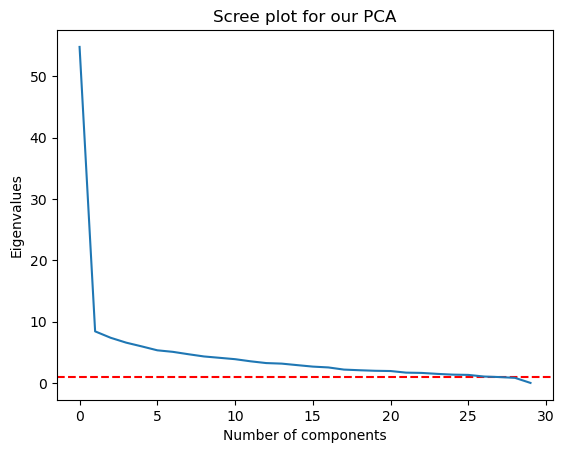

In [128]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns).copy()

%matplotlib inline

pca_screeplot = PCA(n_components=3)
pca_screeplot.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

# Percentage variance explaines
ratio = pca_screeplot.explained_variance_ratio_
print('The 2D PCA contains',round((ratio[0]+ratio[1])*100,4),'% of the information' )
print("")
print ('Component 1 contains',ratio[0]*100,'% of the information' )
print ('Component 2 contains',ratio[1]*100,'% of the information' )
print ('Component 3 contains',ratio[2]*100,'% of the information' )
print("")
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2]]))*100,'% of the information has been lost' )

#Scree Plot
plt.ylabel("Eigenvalues")
plt.xlabel("Number of components")
plt.title("Scree plot for our PCA")
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.show()

By choosing 2 components, we lose more than 50% of the information so maybe our features are not all relevant, and we may miss some features. Also, our analysis may lack some elements but we will probably expand it in the future. However, the first principal component explains 37% of the information which we hope will be able to discriminate our clusters.

Let's visualize which features are correlated with the principal components:

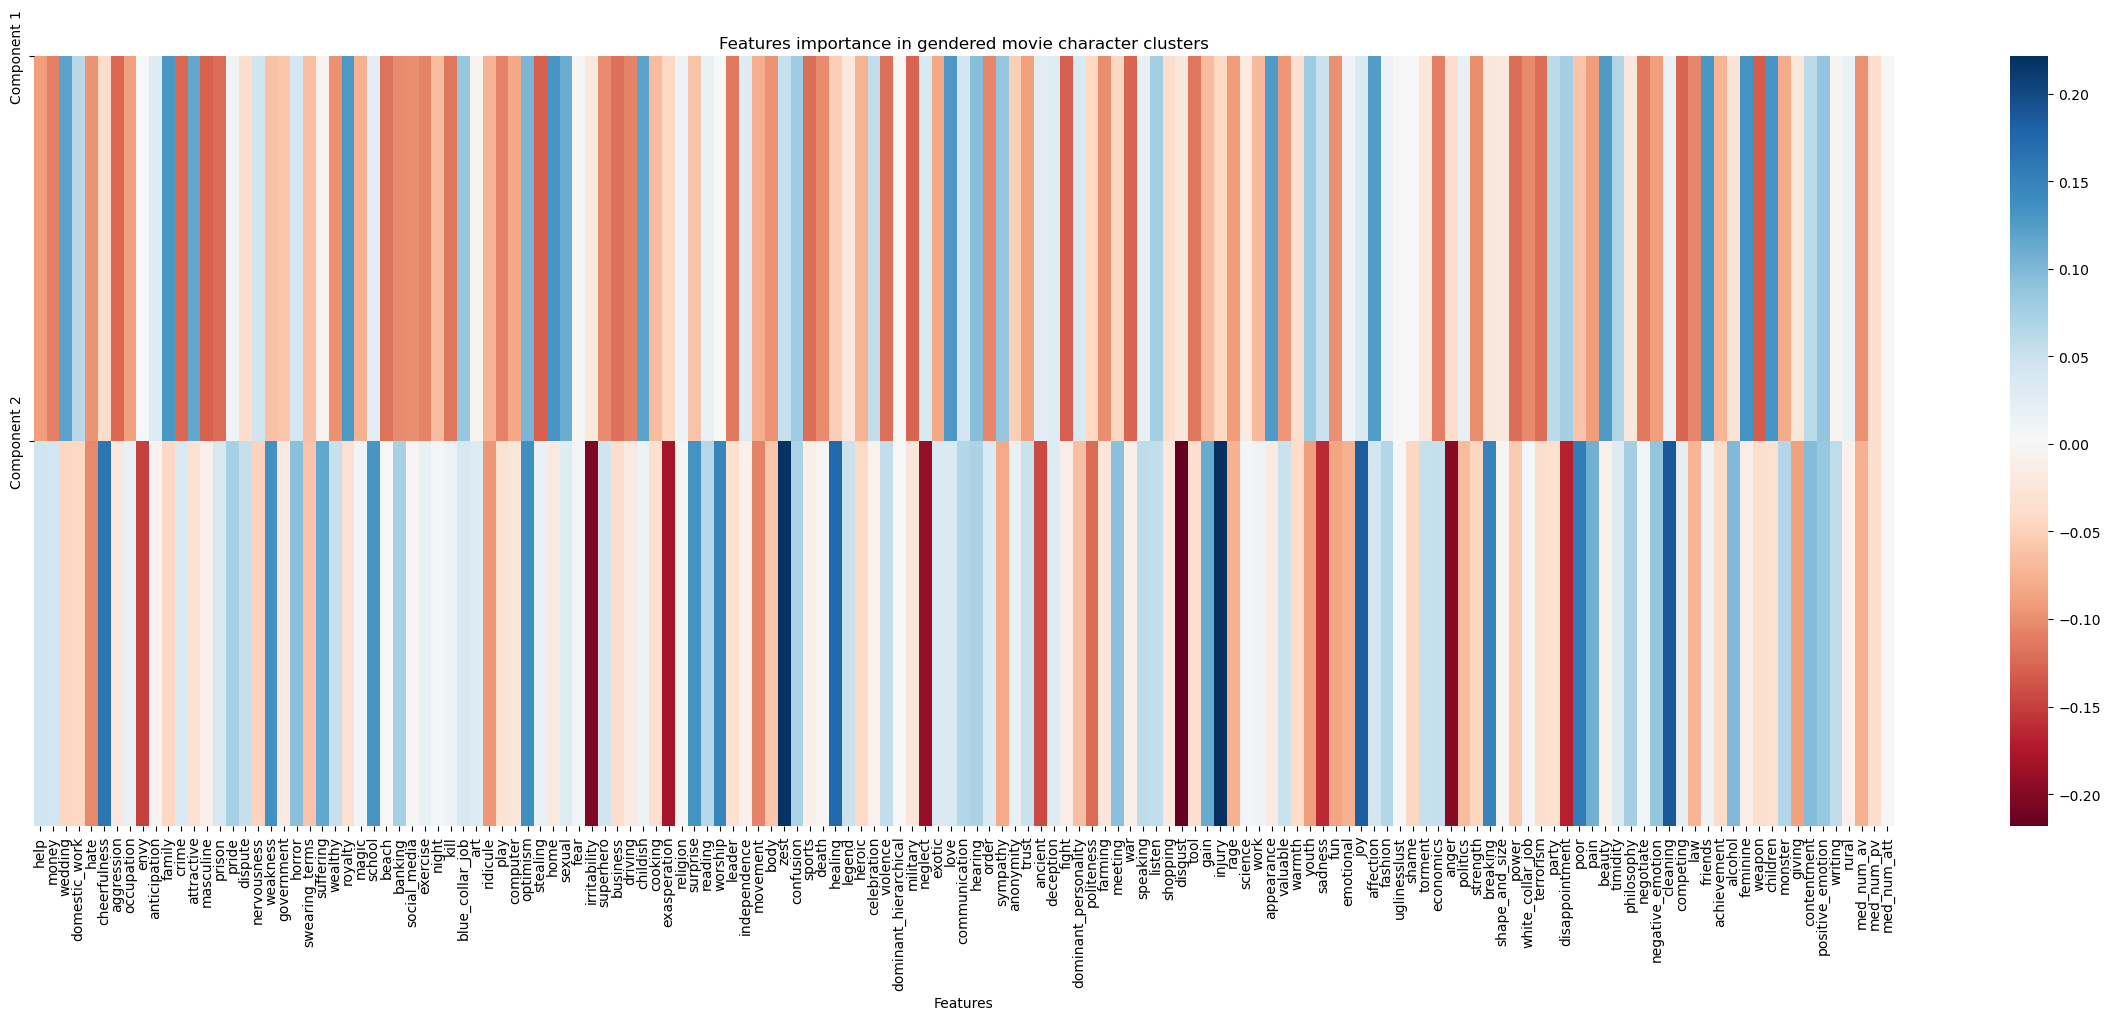

In [129]:
%matplotlib inline
plt.figure(figsize=(30,10))

pca_2d = PCA(n_components=2)
pca_2d.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

map_ = pd.DataFrame(pca_2d.components_,columns=scaled_df.columns)
sns.heatmap(map_, cmap = "RdBu", xticklabels=True, yticklabels=True)
plt.title("Features importance in gendered movie character clusters")
plt.yticks([0,1],['Component 1','Component 2'], fontsize=10)
plt.xlabel('Features')
plt.show()

We can see that the first component is more or less positively or negatively correlated with all of our lexical fields features but some categories are not correlated at all, which can help us to select the most relevant categories for our analysis (see later). Interestingly, component 2 seems to be correlated negatively or positively with a lot of emotions topics (contentment, anger, joy, irritability, disappointment, zest, exasperation...).
As a note, we will then be able to merge into two categories positive and negative emotion (they are also one category) to have less features and more results.

In [131]:
#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

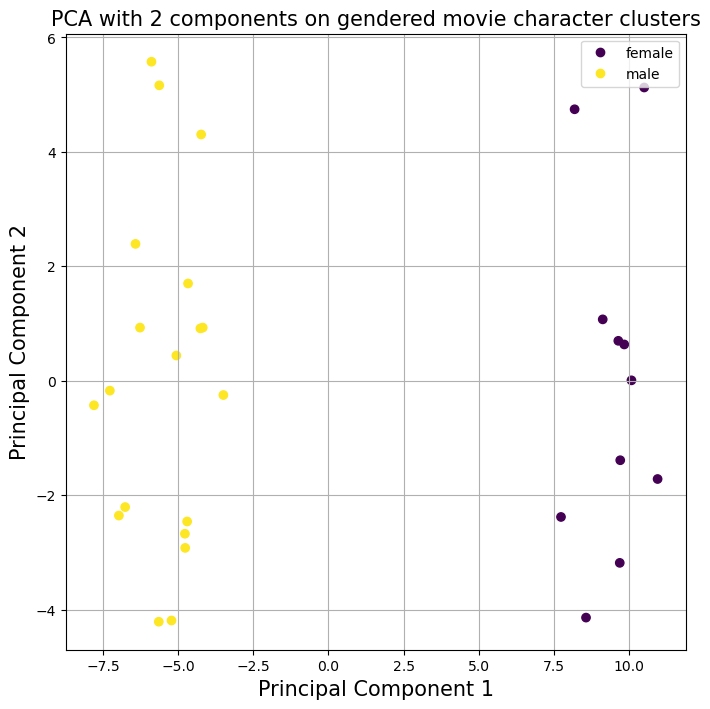

In [136]:
#Visualize results 2D PCA
%matplotlib inline

plt.figure(figsize=(8,8))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  
plt.title("PCA with 2 components on gendered movie character clusters",fontsize=15) 


plot = plt.scatter(res_PCA_2d.loc[:,'Principal component 1'], res_PCA_2d.loc[:,'Principal component 2'], c = y)
labels =[]
#if plot.legend_elements()[1] == 0:
    #labels.append()
plt.legend(handles=plot.legend_elements()[0], labels=['female', 'male'])

plt.grid()
plt.savefig("data/PCA_visualization.png")
plt.show()

From the results of our PCA, we can see that we can clearly distinguish male and female clusters with the lexical fields associated to describe them in the movie. However, from component 2 we cannot really distinguish the gender but the clusters seem to form different categories that we could distinguish with this component. 

Relevant correlated features with PC1:

In [134]:
loadings = PCA_2d.components_.T * np.sqrt(PCA_2d.explained_variance_)
loading_matrix = pd.DataFrame(abs(loadings), columns=['PC1', 'PC2'], index=X.columns)
loading_matrix = loading_matrix.sort_values('PC1', ascending = False)
loading_matrix = loading_matrix.loc[loading_matrix['PC1']>0.8]
loading_matrix.drop(columns = ['PC2'], axis = 1)

,PC1
feminine,0.985598
children,0.978077
weapon,0.971613
home,0.967605
friends,0.964536
fight,0.964198
family,0.963292
stealing,0.958513
masculine,0.953608
royalty,0.952744
